# Support Vector Machines

Les SVM (Support vector machines) constituent une classe particulièrement puissante et flexible d'algorithmes supervisés pour la classification et la régression.
Dans cette section, nous allons développer l'intuition derrière les machines à vecteurs de support et leur utilisation dans les problèmes de classification.


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Pourquoi les SVM ?

Dans le cadre de notre présentation de la classification bayésienne, nous avons appris un modèle simple décrivant la distribution de chaque classe sous-jacente et utilisé ces modèles génératifs pour déterminer de manière probabiliste les étiquettes des nouveaux points.
Il s'agissait d'un exemple de *classification générative* ; ici, nous allons plutôt considérer la *classification discriminative* : plutôt que de modéliser chaque classe, nous trouvons simplement une ligne ou une courbe (en deux dimensions) ou un collecteur (en plusieurs dimensions) qui sépare les classes les unes des autres.

À titre d'exemple, considérons le cas simple d'une tâche de classification, dans laquelle les deux classes de points sont bien séparées :

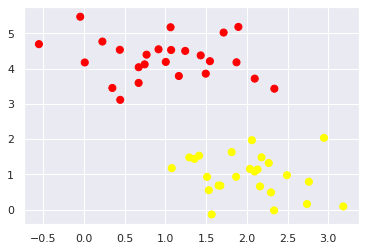

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Un classificateur discriminant linéaire tenterait de tracer une ligne droite séparant les deux ensembles de données, et créerait ainsi un modèle de classification.
Pour des données bidimensionnelles comme celles présentées ici, il s'agit d'une tâche que nous pourrions effectuer à la main.
Mais nous voyons immédiatement un problème : il y a plus d'une ligne de séparation possible qui peut parfaitement discriminer entre les deux classes !

Nous pouvons les dessiner comme suit :

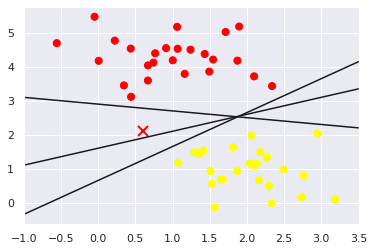

In [ ]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

Il s'agit de trois séparateurs différents qui, néanmoins, discriminent parfaitement ces échantillons.
Selon celui que vous choisissez, un nouveau point de données (par exemple, celui marqué par le "X" dans ce graphique) se verra attribuer une étiquette différente !
De toute évidence, notre simple intuition consistant à "tracer une ligne entre les classes" n'est pas suffisante, et nous devons réfléchir un peu plus en profondeur.

## SVM : Maximiser la marge

Les SVM offrent un moyen d'améliorer cette situation.
L'intuition est la suivante : plutôt que de simplement tracer une ligne de largeur nulle entre les classes, nous pouvons tracer autour de chaque ligne une *marge* d'une certaine largeur, jusqu'au point le plus proche.
Voici un exemple de ce que cela pourrait donner :

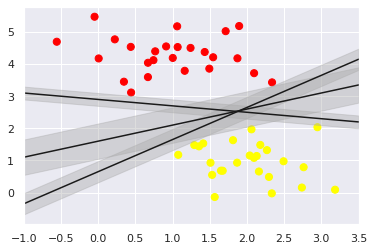

In [ ]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

Dans les SVM, la ligne qui maximise cette marge est celle que nous choisirons comme modèle optimal.
Les machines à vecteurs de support sont un exemple d'un tel estimateur à *marge maximale*.

### Ajustement d'un SVM

Voyons le résultat d'un ajustement réel de ces données : nous allons utiliser le SVM de Scikit-Learn pour entraîner un modèle SVM sur ces données.
Pour l'instant, nous utiliserons un noyau linéaire et nous fixerons le paramètre "C" à un nombre très élevé (nous discuterons de la signification de ces paramètres plus en profondeur dans un instant).

In [ ]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

Pour mieux visualiser ce qui se passe ici, créons une fonction qui tracera les limites de décision du SVM pour nous :

In [ ]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

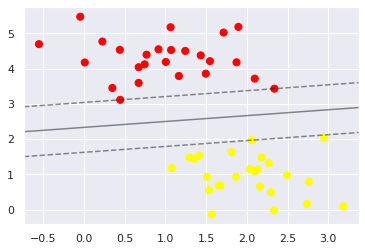

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

Il s'agit de la ligne de démarcation qui maximise la marge entre les deux ensembles de points.
Remarquez que quelques points de formation touchent juste la marge.
Ces points sont les éléments pivots de cet ajustement, et sont connus sous le nom de *vecteurs de soutien*, et donnent son nom à l'algorithme.
Dans Scikit-Learn, l'identité de ces points est stockée dans l'attribut ``support_vectors_`` du classificateur :

In [ ]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

L'une des clés du succès de ce classificateur est que, pour l'ajustement, seule la position des vecteurs de support compte ; tous les points plus éloignés de la marge qui sont du bon côté ne modifient pas l'ajustement !
Techniquement, c'est parce que ces points ne contribuent pas à la fonction de perte utilisée pour ajuster le modèle, donc leur position et leur nombre n'ont pas d'importance tant qu'ils ne traversent pas la marge.

Nous pouvons le constater, par exemple, si nous traçons le modèle appris à partir des 60 premiers points et des 120 premiers points de cet ensemble de donnée

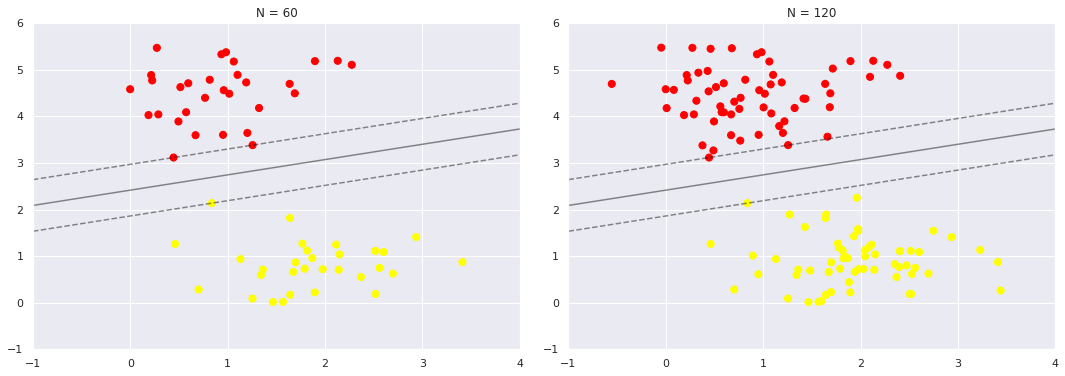

In [ ]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)

    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

Dans le panneau de gauche, nous voyons le modèle et les vecteurs de support pour 60 points d'apprentissage.
Dans le panneau de droite, nous avons doublé le nombre de points d'apprentissage, mais le modèle n'a pas changé : les trois vecteurs de support du panneau de gauche sont toujours les vecteurs de support du panneau de droite.
Cette insensibilité au comportement exact des points éloignés est l'une des forces du modèle SVM.

Si vous exécutez ce notebook en direct, vous pouvez utiliser les widgets interactifs d'IPython pour visualiser cette caractéristique du modèle SVM de manière dynamique :

In [ ]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

### Au-delà des limites linéaires : SVM à noyau

Le SVM devient extrêmement puissant lorsqu'il est combiné avec des *noyaux*.
Pour expliquer la nécessité des noyaux, examinons des données qui ne sont pas linéairement séparables :

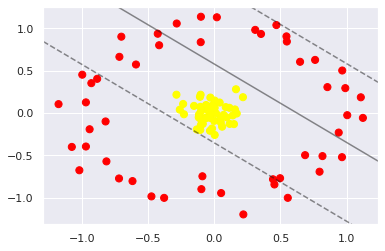

In [ ]:
from sklearn.datasets import make_circles

X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Il est clair qu'aucune discrimination linéaire ne sera *jamais* en mesure de séparer ces données.
Par exemple, une projection simple que nous pourrions utiliser consisterait à calculer une *fonction de base radiale* centrée sur la masse centrale :

In [ ]:
r = np.exp(-(X ** 2).sum(1))

Nous pouvons visualiser cette dimension supplémentaire des données à l'aide d'un graphique tridimensionnel. Si vous exécutez ce bloc-notes en direct, vous pourrez utiliser les curseurs pour faire pivoter le graphique :

In [ ]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

Nous pouvons voir qu'avec cette dimension supplémentaire, les données deviennent trivialement linéairement séparables, en traçant un plan de séparation à, disons, *r*=0,7.

Ici, nous avons dû choisir et ajuster soigneusement notre projection : si nous n'avions pas centré notre fonction de base radiale au bon endroit, nous n'aurions pas obtenu des résultats aussi nets et linéairement séparables.
En général, la nécessité de faire un tel choix est un problème : nous aimerions pouvoir trouver automatiquement les meilleures fonctions de base à utiliser.

Une stratégie à cette fin consiste à calculer une fonction de base centrée sur *chaque* point de l'ensemble de données, et à laisser l'algorithme SVM passer les résultats au crible.
Ce type de transformation de la fonction de base est connu sous le nom de *transformation du noyau*, car il est basé sur une relation de similarité (ou noyau) entre chaque paire de points.

Un problème potentiel avec cette stratégie - projeter $N$ points dans $N$ dimensions - est qu'elle peut devenir très intensive en termes de calcul lorsque $N$ devient grand.
Cependant, grâce à une petite procédure astucieuse connue sous le nom de [*kernel trick*] (https://en.wikipedia.org/wiki/Kernel_trick), un ajustement sur des données transformées par le noyau peut être effectué implicitement, c'est-à-dire sans jamais construire la représentation complète à N$ dimensions de la projection du noyau !
Cette astuce de noyau est intégrée au SVM, et c'est l'une des raisons pour lesquelles cette méthode est si performante.

Dans Scikit-Learn, nous pouvons appliquer un SVM à noyau en changeant simplement notre noyau linéaire en un noyau RBF (radial basis function), en utilisant l'hyperparamètre de modèle ``kernel`` :

In [ ]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

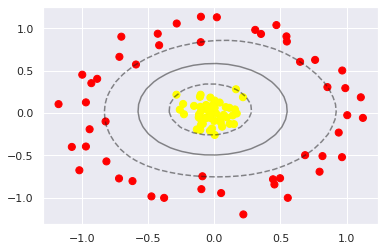

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

En utilisant ce SVM à noyau, nous apprenons une délimitation de décision non linéaire appropriée.
Cette stratégie de transformation par noyau est souvent utilisée en apprentissage automatique pour transformer des méthodes linéaires rapides en méthodes non linéaires rapides, en particulier pour les modèles dans lesquels l'astuce du noyau peut être utilisée.

### Réglage du SVM : Adoucir les marges

Jusqu'à présent, notre discussion s'est concentrée sur des ensembles de données très propres, dans lesquels une frontière de décision parfaite existe.
Mais que se passe-t-il si vos données présentent un certain degré de chevauchement ?
Par exemple, vous pouvez avoir des données comme celles-ci :

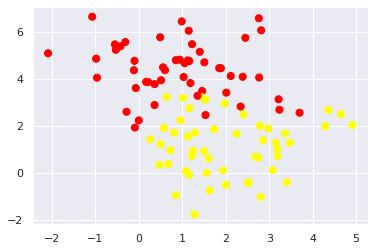

In [ ]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Pour gérer ce cas, l'implémentation du SVM possède un facteur d'ajustement qui "adoucit" la marge : c'est-à-dire qu'elle permet à certains points de se glisser dans la marge si cela permet un meilleur ajustement.
La dureté de la marge est contrôlée par un paramètre d'ajustement, le plus souvent connu sous le nom de $C$.
Pour une valeur très élevée de $C$, la marge est dure et les points ne peuvent pas s'y trouver.
Pour des $C$ plus petits, la marge est plus souple et peut s'élargir pour englober certains points.

Le graphique ci-dessous donne une image visuelle de la façon dont un paramètre $C$ changeant affecte l'ajustement final, via l'adoucissement de la marge :

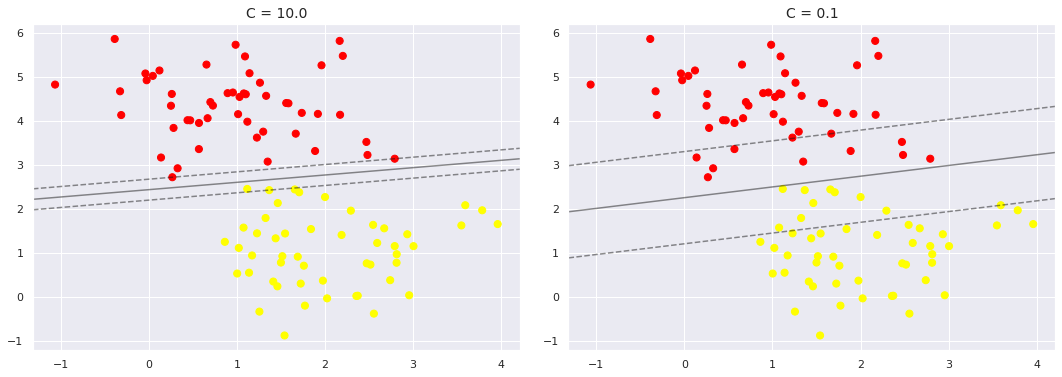

In [ ]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

La valeur optimale du paramètre $C$ dépendra de votre ensemble de données, et devrait être réglée en utilisant la validation croisée ou une procédure similaire.

## Exemple : Reconnaissance des visages

Pour illustrer l'action des SVM, examinons le problème de la reconnaissance faciale.
Nous utiliserons le jeu de données Labeled Faces in the Wild, qui consiste en plusieurs milliers de photos de diverses personnalités publiques.
Un extracteur pour ce jeu de données est intégré à Scikit-Learn :

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


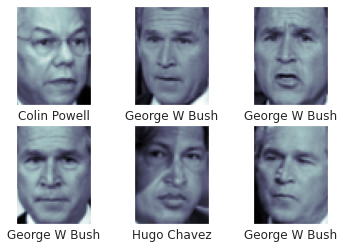

In [ ]:
fig, ax = plt.subplots(2, 3)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Chaque image contient [62×47], soit près de 3 000 pixels.
Nous pourrions nous contenter d'utiliser la valeur de chaque pixel comme caractéristique, mais il est souvent plus efficace d'utiliser une sorte de préprocesseur pour extraire des caractéristiques plus significatives ; ici, nous allons utiliser une analyse en composantes principales pour extraire 150 composantes fondamentales à intégrer dans notre SVM.
Pour ce faire, il suffit de regrouper le préprocesseur et le classificateur en un seul pipeline :

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Enfin, nous pouvons utiliser une validation croisée par recherche sur grille pour explorer les combinaisons de paramètres.
Ici, nous allons ajuster ``C`` (qui contrôle la dureté de la marge) et ``gamma`` (qui contrôle la taille du noyau de la fonction de base radiale), et déterminer le meilleur modèle :

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 58.9 s, sys: 39.4 s, total: 1min 38s
Wall time: 53.8 s
{'svc__C': 10, 'svc__gamma': 0.001}


Les valeurs optimales se situent vers le milieu de notre grille ; si elles se situaient sur les bords, nous devrions élargir la grille pour nous assurer que nous avons trouvé le véritable optimum.

Maintenant, avec ce modèle à validation croisée, nous pouvons prédire les étiquettes des données de test, que le modèle n'a pas encore vues :

In [ ]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

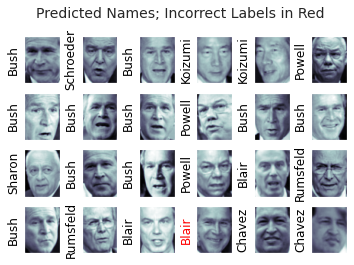

In [ ]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



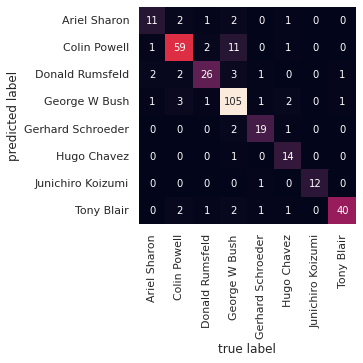

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Pour une tâche de reconnaissance faciale dans le monde réel, dans laquelle les photos ne sont pas recadrées dans de jolies grilles, la seule différence dans le schéma de classification faciale est la sélection des caractéristiques : vous devrez utiliser un algorithme plus sophistiqué pour trouver les visages, et extraire des caractéristiques qui sont indépendantes de la pixellisation.
Pour ce type d'application, une bonne option est d'utiliser [OpenCV] (http://opencv.org), qui, entre autres, comprend des implémentations pré-entraînées d'outils d'extraction de caractéristiques de pointe pour les images en général et les visages en particulier.

## Résumé des SVM

Nous avons vu ici une brève introduction intuitive aux principes qui sous-tendent les SVM.
Ces méthodes constituent une méthode de classification puissante pour un certain nombre de raisons :

- Leur dépendance à l'égard d'un nombre relativement faible de vecteurs de support signifie qu'il s'agit de modèles très compacts, qui occupent très peu de mémoire.
- Une fois le modèle entraîné, la phase de prédiction est très rapide.
- Parce qu'ils ne sont affectés que par les points proches de la marge, ils fonctionnent bien avec des données à haute dimension - même des données avec plus de dimensions que d'échantillons, ce qui est un régime difficile pour d'autres algorithmes.
- Leur intégration aux méthodes à noyau les rend très polyvalents, capables de s'adapter à de nombreux types de données.

Cependant, les SVM présentent également plusieurs inconvénients :

- L'échelle avec le nombre d'échantillons $N$ est de $\mathcal{O}[N^3]$ au pire, ou de $\mathcal{O}[N^2]$ pour les implémentations efficaces. Pour un grand nombre d'échantillons d'entraînement, ce coût de calcul peut être prohibitif.
- Les résultats dépendent fortement d'un choix approprié pour le paramètre d'adoucissement $C$. Celui-ci doit être choisi avec soin par validation croisée, ce qui peut s'avérer coûteux lorsque la taille des ensembles de données augmente.
- Les résultats n'ont pas d'interprétation probabiliste directe. Cela peut être estimé via une validation croisée interne (voir le paramètre ``probabilité`` de ``SVC``), mais cette estimation supplémentaire est coûteuse.

Avec ces caractéristiques en tête, je ne me tourne généralement vers les SVMs qu'une fois que d'autres méthodes plus simples, plus rapides et moins exigeantes en réglages se sont révélées insuffisantes pour mes besoins.
Néanmoins, si vous avez les cycles de CPU à consacrer à l'entraînement et à la validation croisée d'un SVM sur vos données, la méthode peut conduire à d'excellents résultats.